In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Ingesting data
con = sqlite3.connect("csgo.db")
csgo_df = pd.read_sql_query("SELECT * FROM round INNER JOIN game WHERE round.game_id = game.id", con, parse_dates=["time"])
players_df = pd.read_sql_query("SELECT * from players", con)
csgo_df['time'] = pd.to_datetime(csgo_df['time'], utc=True)

# Some Pandas visual display options to read the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [67]:
csgo_df['survivingCount'] =  csgo_df.survivingPlayers.apply(lambda x: len(x[1:-1].split(',')) if x != 'null' else 0)
csgo_df['longestKillWaitS'] = csgo_df['longestKillWait']/csgo_df['tickrate']
csgo_df['lastKillToEndS'] = csgo_df['lastKillToEnd']/csgo_df['tickrate']

In [68]:
csgo_df



,round_id,game_id,duration,losingTeamName,losingSide,startTick,endTick,endOfficialTick,survivingPlayers,losingTeamLeftoverMoney,equipmentSavedValue,killTicks,smokeTicks,molotovTicks,heTicks,longestKillWait,lastKillToEnd,round_no,heDamage,id,time,team_a,team_b,team_a_players,team_b_players,map,tickrate,survivingCount,longestKillWaitS,lastKillToEndS
0,1,1,78,Team LDLC.com,3,4992,15016,15915,null,7950,0,"[11896,12096,13024,13680,14536,15016]","[6440,13168]",null,null,928,0,0,0,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197960710573,76561197974587647]","[76561197982036918,76561197961191700,76561197960359452,76561197984560929,76561197986490720]",de_dust2,128,0,7.2500,0.0000
1,2,1,97,Team LDLC.com,3,17835,30283,31181,null,9800,0,"[23891,24147,28371,30371,30907]","[18915,20019,24075,24275]",null,[22219],4224,1912,1,0,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197960710573,76561197974587647]","[76561197982036918,76561197961191700,76561197960359452,76561197984560929,76561197986490720]",de_dust2,128,0,33.0000,14.9375
2,3,1,87,Team LDLC.com,3,33101,44341,45237,"[""LDLC NBKTANK- * CMSTORM"",""LDLC Happy * CMSTORM"",""LDLC kiokiNg/w/ * CMSTORM"",""LDLC SMITHZZ * CMSTORM"",""LDLC shox * CMSTORM""]",21800,1000,null,"[38877,39453]",null,"[35205,38389,38613,39157,44597]",0,0,2,0,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197960710573,76561197974587647]","[76561197982036918,76561197961191700,76561197960359452,76561197984560929,76561197986490720]",de_dust2,128,5,0.0000,0.0000
3,4,1,87,Ninjas in Pyjamas,2,47157,58365,59267,null,36950,0,"[52725,54181,55565,56085,56461,56989,58365]","[47677,47893,48133,49709,52957,53325,55069,58293]",null,"[49037,49597,49693,50349,55573]",1456,0,3,0,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197960710573,76561197974587647]","[76561197982036918,76561197961191700,76561197960359452,76561197984560929,76561197986490720]",de_dust2,128,0,11.3750,0.0000
4,5,1,105,Ninjas in Pyjamas,2,61179,74619,75521,"[""Xizt Xtrfy""]",20500,4700,"[70179,70411,71379,71643,72371,72771,73563,73763]","[61491,61995,62211,67155,68043,69715,70035,70731,70987,71187]",null,"[62723,63915,64483,67683,72059,72779]",968,856,4,0,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197960710573,76561197974587647]","[76561197982036918,76561197961191700,76561197960359452,76561197984560929,76561197986490720]",de_dust2,128,1,7.5625,6.6875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18919,19298,724,86,Team EnVyUs,2,254671,265727,266626,null,13850,0,"[259359,259559,261735,262167,262319,263175,263527,265727]","[255079,255543,256175,257967,259703,260007,262159]",null,"[256799,257831,263815]",2200,0,21,0,724,2015-03-14 21:25:16+00:00,Team EnVyUs,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197974587647,76561197960710573]","[76561197984560929,76561197982036918,76561197960359452,76561197986490720,76561197961610974]",de_dust2,128,0,17.1875,0.0000
18920,19299,724,60,Team EnVyUs,2,268546,276290,277190,null,18250,0,"[271906,272066,272306,272794,273018,273394,276290]","[269210,270298,270618,271362,271490,275026]",[269858],"[269730,269746,269810,269970]",2896,0,22,0,724,2015-03-14 21:25:16+00:00,Team EnVyUs,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,76561198006920295,76561197974587647,76561197960710573]","[76561197984560929,76561197982036918,76561197960359452,76561197986490720,76561197961610974]",de_dust2,128,0,22.6250,0.0000
18921,19300,724,67,Ninjas in Pyjamas,3,279110,287742,288644,null,16500,0,"[281430,282878,284814,286774,287198,287710,287742]","[279958,280422,280942,

Create some averages of the data. For numerical values, we can immediately plot them.

In [69]:
yearly_average = csgo_df.resample("Y", on="time")
yearly_average.mean().dropna()
;

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/1524761603.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_average.mean().dropna()


''

In [70]:
monthly_average = csgo_df.resample("M", on="time")
monthly_average.mean().dropna()
;

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/330764374.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average.mean().dropna()


''

The average duration of CS:GO rounds. As you can see, a clear upwards trend.

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/1175145296.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  duration_plot = monthly_average[["time", "duration"]].mean().dropna()


<Axes: xlabel='time'>

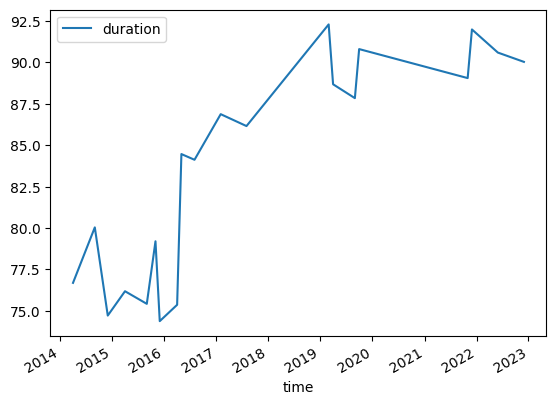

In [71]:
duration_plot = monthly_average[["time", "duration"]].mean().dropna()
duration_plot.plot()

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/683167702.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()


<Axes: xlabel='time'>

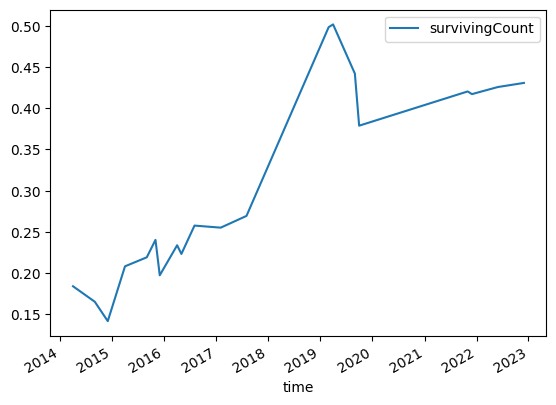

In [72]:
survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()
survivingp_plot.plot()

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/3828588760.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average[['time', 'heDamage']].mean().dropna().plot()


<Axes: xlabel='time'>

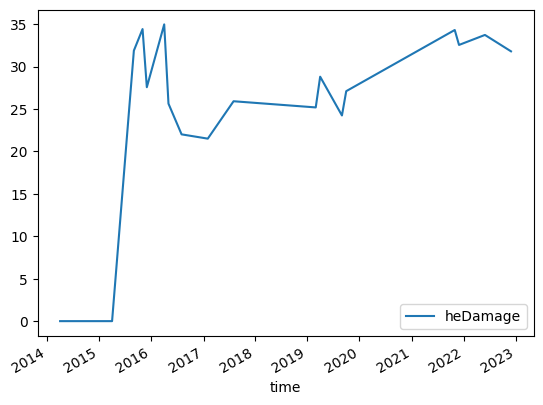

In [73]:
monthly_average[['time', 'heDamage']].mean().dropna().plot()

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/538616652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()


<Axes: xlabel='time'>

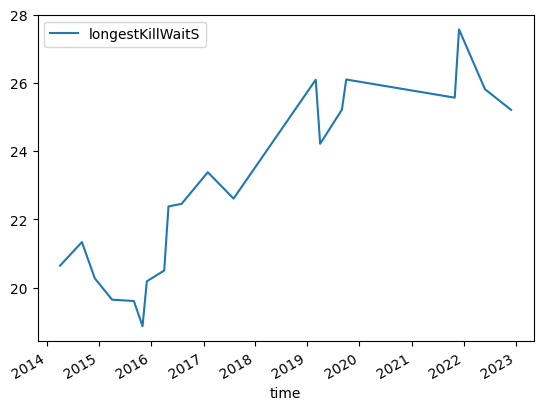

In [74]:
longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()
longestkill_plot.plot()

/var/folders/7d/39jb4p596h9fd9tfrm8p0nvm0000gn/T/ipykernel_41389/3064090705.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average[['time', 'lastKillToEndS']].mean().dropna().plot()


<Axes: xlabel='time'>

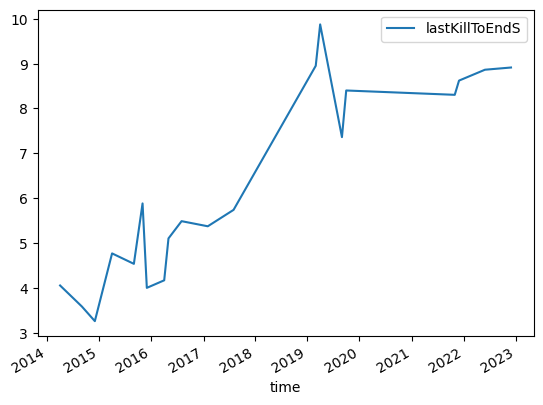

In [75]:
monthly_average[['time', 'lastKillToEnd']].mean().dropna().plot()

In [76]:
csgo_df["team_a_players_str"] = csgo_df.team_a_players.apply(lambda x: str(sorted(x[1:-1].split(','))))
csgo_df["team_b_players_str"] = csgo_df.team_b_players.apply(lambda x: str(sorted(x[1:-1].split(','))))
csgo_df["team_a_players"] = csgo_df.team_a_players.apply(lambda x: sorted(map(int, x[1:-1].split(','))))
csgo_df["team_b_players"] = csgo_df.team_b_players.apply(lambda x: sorted(map(int, x[1:-1].split(','))))
csgo_df["losingPlayers"] = np.where(csgo_df["losingTeamName"] == csgo_df["team_a"],  csgo_df["team_a_players"], csgo_df["team_b_players"])
csgo_df["losingPlayers_str"] = np.where(csgo_df["losingTeamName"] == csgo_df["team_a"],  csgo_df["team_a_players_str"], csgo_df["team_b_players_str"])

In [77]:
csgo_df.map.explode().value_counts()

de_mirage      3148
de_inferno     3129
de_dust2       2533
de_overpass    2200
de_nuke        1879
de_cbble       1649
de_train       1546
de_cache       1267
de_vertigo      871
de_ancient      702
Name: map, dtype: int64

In [78]:
survivingRounds = csgo_df.loc[csgo_df["survivingCount"] > 0]
survivingRounds
;

''

This should be accurate in calculating the teams that save the most. 

In [79]:
survivingRounds.losingPlayers.value_counts()

[76561197960499780, 76561197960725934, 76561197973845818, 76561197979126082, 76561197982141573]    113
[76561197996678278, 76561198004115516, 76561198022365638, 76561198064864198, 76561198160709585]     82
[76561197965809411, 76561197977105184, 76561197985097994, 76561198002708642, 76561198072321716]     77
[76561197995817501, 76561198036125584, 76561198127236290, 76561198134401925, 76561198173201923]     74
[76561197969684910, 76561197988627193, 76561197991348083, 76561198031554200, 76561198031651584]     72
                                                                                                  ... 
[76561197971426269, 76561197972971414, 76561197984400619, 76561197993906342, 76561198017015164]      1
[76561197960301489, 76561197972003061, 76561197974587647, 76561198006920295, 76561198014251501]      1
[76561197960784488, 76561197967489380, 76561197977830434, 76561197978481975]                         1
[76561197960429732, 76561197961021014, 76561197964781654, 765611979813414

This is not a list of the most saved players - it is a list of players on teams that save the most. dupreeh might not have saved 235 times, but the teams he's been on have.

I would say that Jame and Qikert's position is quite notable. 

In [80]:
survivingRounds.losingPlayers.explode().value_counts().to_frame().reset_index().rename(columns={"index":"SteamID64", "losingPlayers": "roundsSaved"}).merge(players_df)[['name', 'roundsSaved']].groupby('roundsSaved').agg(list)

,name
roundsSaved,
1,"[KHRN, disturbed, stonde, natu, blackpoisoN #RAZER, racno-.`SGMF.<..>, cent #ALIENWARE, deviaNt #COREX, Detrony #INTEL, AcilioN, HUNDEN, xartE]"
2,"[WOLF > astaRRRRR, WOLF > Mithil:D, WOLF > RiTz, desi, WOLF > Ace, WOLF > R i X, oSee, James]"
3,"[zEVES, Polly * XTRFY, steel * ADATA, ub1que, ptr, yam]"
4,[THREAT]
5,"[zehN, koosta, suNny, innocent, [R]eason LOMME * SteelSeries, HS, [R]eason EXR * SteelSeries, DEVIL, pita]"
...,...
200,[s1mple &L POWER]
205,[device -M-]
215,"[Qikert, Jame, Zeu$ -_^]"


This needs to be a SteamID64 like the above to be sure, but we can have a bit of an initial look here.

Again, jesus Jame.

In [81]:
csgo_df["survivingPlayers"] = csgo_df.survivingPlayers.apply(lambda x: sorted(x[1:-1].split(',')) if x != "null" else [])

In [82]:
csgo_df.survivingPlayers.explode().value_counts().to_frame().reset_index(names="playerName")[['playerName', 'survivingPlayers']].groupby('survivingPlayers').agg(list)

,playerName
survivingPlayers,
1,"[""Golden"", ""sem \u003e"", ""SEMPHIS"", ""xartE"", ""CW Pimp * Obutto"", ""DaZeD Netcodeguides.com"", ""Havoc[K] MSi"", ""kucherYL"", ""zEVES"", ""Skadoodle * WD"", ""cent #ALIENWARE"", ""SPUNJ MSi"", ""ub1que"", ""jks MSi"", ""AZR[m] MSi"", ""yam"", ""Spiidi *Platincasino"", ""Snax'd"", ""[R]eason EXR * SteelSeries"", ""[R]eason smF * Steelseries"", ""HaRtsSsSsSs * ZOWIE GEAR"", ""device-"", ""olofmeister * MAXFPS.com"", ""iBP Skadoodle"", ""Havoc"", ""apEX[D] * CM Storm"", ""SPUNJ"", ""Virtus.pro \u003e byali"", ""NiP-f0rest-"", ""NiP-friberg-"", ""Stanislaw"", ""TazmanianDevil"", ""nij0"", ""device -M-"", ""rallen"", ""byalko"", ""smF"", ""fR11$HAAA"", ""znajder"", ""AcilioN"", ""DavCost"", ""Professor_Chaos"", ""swag"", ""hooch"", ""innocent"", ""zehN"", ""kNgV-"", ""jR"", ""(1)GeT_RiGhT""]"
2,"[""DEVIL"", ""pronax * Steelseries"", ""CW cajunb * SteelSeries"", ""CW gla1ve * Cooler Master"", ""WOLF \u003e RiTz"", ""Hyper"", ""f0rest Komplett.se"", ""Dosia*S"", ""STYKO"", ""THREAT"", ""koosta"", ""coL.seang@res \u003cSoundBlaster\u003e"", ""USTILO"", ""denis *Platincasino"", ""Spiidi *Antec"", ""abE"", ""cadiaN[S]"", ""keshandr"", ""oskar"", ""suNny"", ""zonic"", ""rigoN"", ""fel1x *Arctic"", ""shroud \u003cHyperX\u003e"", ""GruBy"", ""Furlan"", ""olofmeister * AZUBU"", ""angelYL"", ""Zeus =D \u003c3"", ""Troubley"", ""kRYSTAL"", ""zqkS"", ""iBP AZK"", ""iBP anger"", ""flusha * Fragnet"", ""[R]eason karrigaN"", ""NiP-Fifflaren-"", ""EPSILON Sf * GAMDIAS"", ""n0thing \u003cLogitech\u003e"", ""Virtus.pro \u003e TaZ"", ""coL.swag \u003cSoundBlaster\u003e"", ""CW KARRiGAN * Komplett"", ""coL.n0thing \u003cSoundBlaster\u003e"", ""steel * ADATA""]"
3,"[""Zero"", ""NiP-Xizt-"", ""coL.SEMPHIS \u003cSoundBlaster\u003e"", ""schneider * Fragnet"", ""Xizt Xtrfy"", ""friberg Crucial"", ""iBP DaZeD NetcodeGuides.com"", ""[R]eason Friis"", ""SnypeR"", ""Grim"", ""Virtus.pro \u003e paszaBiceps"", ""SIXER"", ""ANGE1YL"", ""HS"", ""spaze"", ""tenzki[fw]"", ""emagine"", ""James"", ""sg@RESsSSsSsSs \u003cHyperX\u003e"", ""svyat"", ""cajunb -S-"", ""pyth"", ""dennis * Orcbite"", ""SENER1"", ""schneider"", ""ANGE1"", ""pita"", ""LDLC.com KQLY Cooler Master""]"
4,"[""speed4k"", ""FNS"", ""doto"", ""arya"", ""CW Nico * Komplett"", ""mir"", ""LEGIJA"", ""kinqie"", ""LDLC Happy * CMSTORM"", ""JWonderchild"", ""S1ren"", ""pronax * Fragnet"", ""iBP adreN"", ""Virtus.pro \u003e sNax"", ""paszaBiceps"", ""Zeu$ -_^"", ""LDLC.com Uzzziii Cooler Master"", ""Cloud9 CS shroud \u003cHyperX\u003e"", ""twist * Xtrfy"", ""LDLC.com apEX[D] Cooler Master"", ""Cloud9 CS n0thing \u003cHyperX\u003e"", ""mezii"", ""sinnopsyy"", ""s1mple \u0026L POWER"", ""lauNX"", ""krimz * crucial""]"
5,"[""maden"", ""Pimp"", ""MaikeleleRL AKRacing"", ""kennyS * ZOWIE"", ""Devilwalk.teg * Fragnet"", ""JW * Fragnet"", ""kioShiMa /w/ * ZOWIE"", ""Hiko \u003cLogitech-G\u003e"", ""LDLC SMITHZZ * CMSTORM"", ""HooXi"", ""XANTARES"", ""zews"", ""GuardViaN"", ""Staehr"", ""cype * Gunnar Optiks"", ""faveN"", ""TENZKI"", ""twist"", ""disco doplan"", ""Maikelele"", ""peet"", ""juanflatroo""]"
6,"[""tiziaN"", ""Cloud9 CS Hiko \u003cLogitech\u003e"", ""LDLC NBKTANK- * CMSTORM"", ""Zellsis"", ""EPSILON fxy0 * Fragnet"", ""gade"", ""friberg"", ""daps"", ""reltuC"", ""GeT_RiGhT-A- EIZO"", ""B1ad3"", ""MICHU"", ""Lack1"", ""LDLC kiokiNg/w/ * CMSTORM"", ""device ♛ [M]"", ""keev""]"
7,"[""LDLC shox * CMSTORM"", ""FeTiSh[MB]"", ""Brollan"", ""seang@res"", ""loWel""]"
8,"[""FASHR"", ""mixwell"", ""KRIMZ * fnaticShop"", ""kUcheR"", ""Patsi""]"
9,"[""wayLander"", ""huNter-"", ""ShahZaM"", ""HObbit"", ""RUBINO"", ""MSL"", ""gxx-"", ""sdy"", ""LNZ"", ""Ethan"", ""electroNic"", ""s1n"", ""DeadFox"", ""fitch"", ""Shara"", ""freakazoid"", ""Snappi"", ""k1to"", ""NickelBack"", ""acoR"", ""Cloud9 CS seang@res""]"


In [83]:
csgo_df['heTicks'] = csgo_df.heTicks.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != "null" else [])
csgo_df['heTicksRelative'] = csgo_df.apply(lambda x: [y-x.startTick for y in x.heTicks ], axis=1)


<Axes: xlabel='time'>

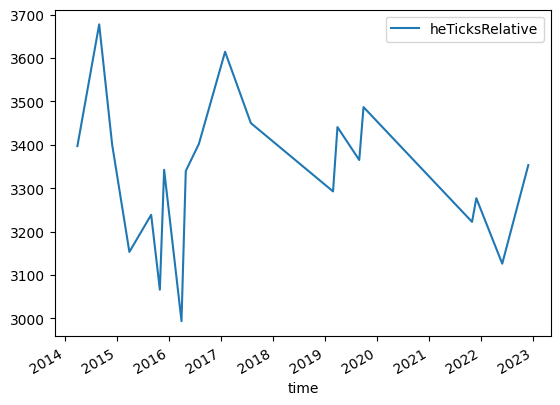

In [85]:
csgo_df[['time', 'heTicksRelative']].explode('heTicksRelative').resample("M", on="time").mean().dropna().plot()